# Exp 1 – XGBoost Regression

##

### 1. Nhập các thư viện cho mô hình

In [34]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### 2. Tải lên file dữ liệu đã qua EDA và Preprocessing

In [35]:
train_path = "../../data/data_afterMVAnalysis/train_features_rmMV.csv"
test_path = "../../data/data_afterMVAnalysis/test_features_rmMV.csv"
target_path = "../../data/data_afterMVAnalysis/target.csv"

train_ = pd.read_csv(train_path)
test_ = pd.read_csv(test_path)
target = pd.read_csv(target_path)

print("Đã tải các tệp dữ liệu đã qua xử lý")

Đã tải các tệp dữ liệu đã qua xử lý


### 3. Logarit hoá biến mục tiêu

In [36]:
y_log = np.log1p(target.values.ravel())
print("Đã log-transform SalePrice")

Đã log-transform SalePrice


In [37]:
# Chia dữ liệu và huấn luyện mô hình
features_train, features_test, target_train, target_test = train_test_split(
    train_, y_log, test_size=0.2, random_state=25
)

print("Đã chia dữ liệu tệp train và test để huấn luyện và đánh giá mô hình")

Đã chia dữ liệu tệp train và test để huấn luyện và đánh giá mô hình


##### thay đổi này giúp mô hình học nhanh hơn

### 4. Khởi tạo model với hyperparameters với RandomizedSearchCV

In [38]:
model_XGB = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=25,
    n_jobs=-1,
    verbosity=1
)

model_XGB.fit(
    features_train, 
    target_train
)

print("Đã huấn luyện xong mô hình XGBoost")

Đã huấn luyện xong mô hình XGBoost


### 5. Đánh giá mô hình

In [ ]:
# Dự đoán log và gốc
y_pred_log = model_XGB.predict(train_)
y_pred_original = np.expm1(y_pred_log)  

# RMSE 
rmse_log = np.sqrt(mean_squared_error(y_log, y_pred_log))

# R^2 
r2_log = r2_score(y_log, y_pred_log)
r2_original = r2_score(target, y_pred_original)

print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"R² (log scale): {r2_log:.4f}")
print(f"R² trên tập train: {r2_original:.4f}")

RMSE (log scale): 0.0657
R² (log scale): 0.9718
R² trên tập train (giá trị gốc): 0.9759


### 6. Đánh giá về điểm và độ ổn định của các Fold

### 7. Tạo file submit bài và lưu file mô hình

In [40]:
test_pred_optimized = model_XGB.predict(test_)

if test_pred_optimized.ndim > 1:
    test_pred_optimized = test_pred_optimized.ravel()

test_pred_final = np.expm1(test_pred_optimized)

# Tạo submission file
submission_optimized = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_pred_final)),  
    'SalePrice': test_pred_final
})

submission_optimized.to_csv('result/XGB_submission.csv', index=False)
print("Đã tạo file XGB_submission.csv")

Đã tạo file XGB_submission.csv


In [41]:
joblib.dump(model_XGB, 'pkl/XGBoost_model.pkl')
print("Đã lưu mô hình XGBoost")

Đã lưu mô hình XGBoost


### 8. Biểu đồ các đặc trưng quan trọng nhất của mô hình

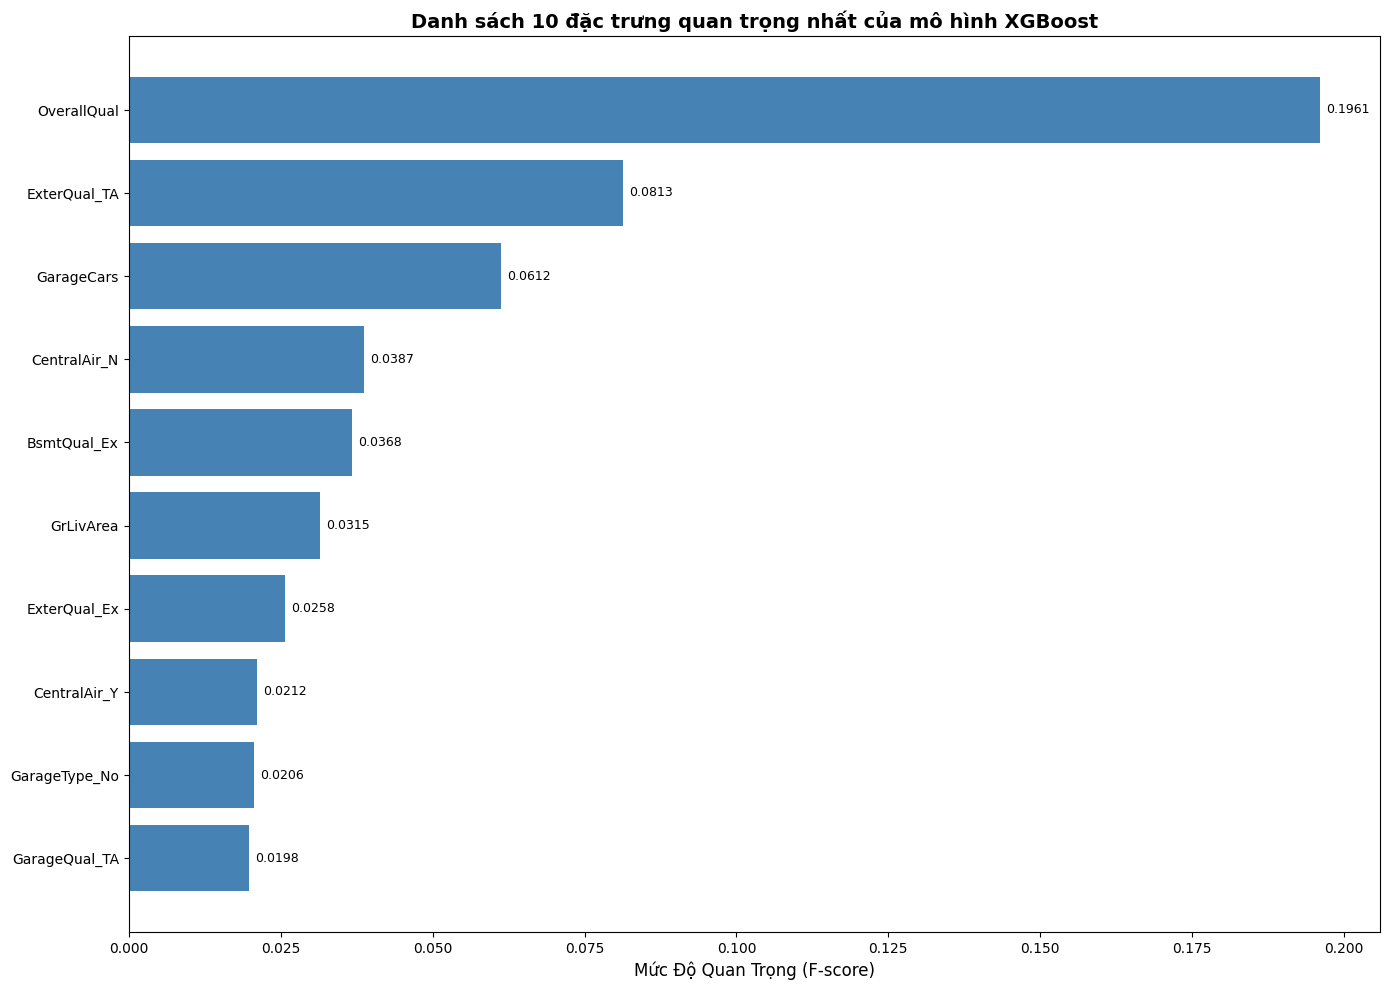

In [42]:
feature_importance = pd.DataFrame({
    'feature': train_.columns,
    'importance': model_XGB.feature_importances_
}).sort_values('importance', ascending=False)

# 10 đặc trưng quan trọng nhất
top_10_features = feature_importance.head(10)
top_10_features_display = top_10_features.iloc[::-1]

# Vẽ biểu đồ 
plt.figure(figsize=(14, 10))
bars = plt.barh(
    top_10_features_display['feature'], 
    top_10_features_display['importance'],
    color='steelblue'
)
plt.title('Danh sách 10 đặc trưng quan trọng nhất của mô hình XGBoost', fontsize=14, fontweight='bold')
plt.xlabel('Mức Độ Quan Trọng (F-score)', fontsize=12)

# Thêm giá trị trên mỗi cột
for bar, importance in zip(bars, top_10_features_display['importance']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.4f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()
